# Импорт нужных пакетов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных для моделирования

In [2]:
deposit_rates = pd.read_excel("data/deposit_rates.xlsx") # данные по максимальной процентной ставки по вкладам
inflation_data = pd.read_excel("data/inflation.xlsx") # данные по инфляции
salaries = pd.read_excel("data/salaries.xlsx") # данные по зарплатам
imoex = pd.read_excel("data/imoex.xlsx") # цена индекса мосбиржи
dollar = pd.read_csv("data/usd_rub.csv", parse_dates = True) # цена usdrub FOREX
sp500 = pd.read_csv("data/spy.csv") # цена spy etf
gold = pd.read_excel("data/gold.xlsx") # аффилированная цена на золото

In [3]:
dollar.date = pd.to_datetime(dollar.date, format = "%d.%m.%Y")
for i in ["close", "open", "high", "low"]:
    dollar[i] = pd.to_numeric(dollar[i].replace(to_replace = ",", value = ".", regex = True).str.strip())

sp500.date = pd.to_datetime(sp500.date, format = "%d.%m.%Y")
for i in ["close", "open", "high", "low"]:
    sp500[i] = pd.to_numeric(sp500[i].replace(to_replace = ",", value = ".", regex = True).str.strip())

## Сравнение ставки по депозитам с инфляцией и ключевой ставкой

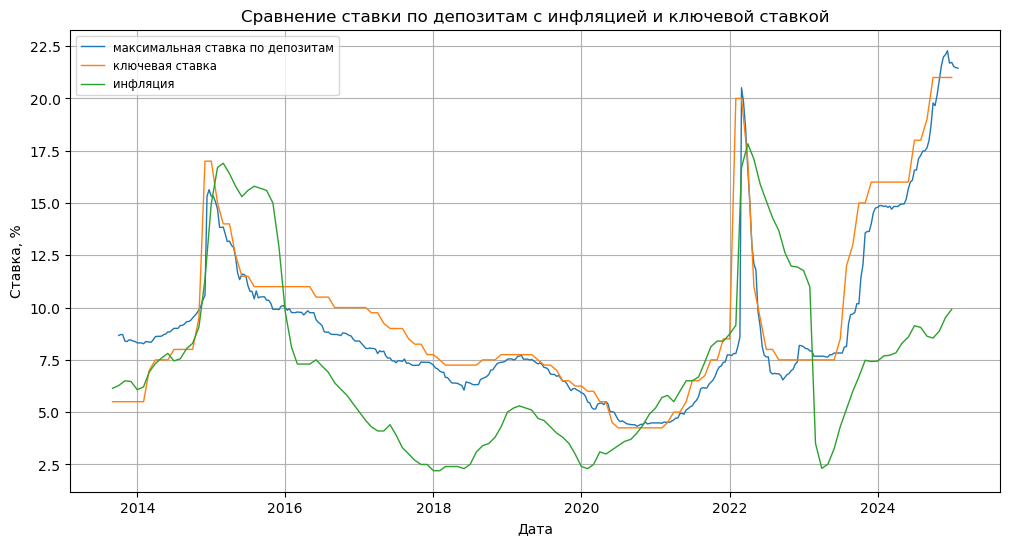

In [4]:
plt.figure(figsize = (12, 6))
plt.plot(deposit_rates["date"], deposit_rates["deposit_rate"], label = "максимальная ставка по депозитам", linewidth = 1)
plt.plot(inflation_data["date"], inflation_data["key_rate"], label = "ключевая ставка", linewidth = 1)
plt.plot(inflation_data["date"], inflation_data["inflation"], label = "инфляция", linewidth = 1)
plt.title("Сравнение ставки по депозитам с инфляцией и ключевой ставкой")
plt.xlabel("Дата")
plt.ylabel("Ставка, %")
plt.legend(fontsize = "small")
plt.grid()

# Моделирование инвестиций в банковские вклады

In [5]:
deposit_inv = pd.merge(salaries, deposit_rates, how = "inner", on = "date")
deposit_inv["avialable_money"] = 0

In [6]:
deposit_inv.loc[0, "avialable_money"] = deposit_inv.loc[0, "salary"] * 0.3
for i in range(1, len(deposit_inv)):
    deposit_inv.loc[i, "avialable_money"] = deposit_inv.loc[i, "salary"] * 0.3 + deposit_inv.loc[i - 1, "avialable_money"] * (deposit_inv.loc[i - 1, "deposit_rate"] / 1200 + 1)

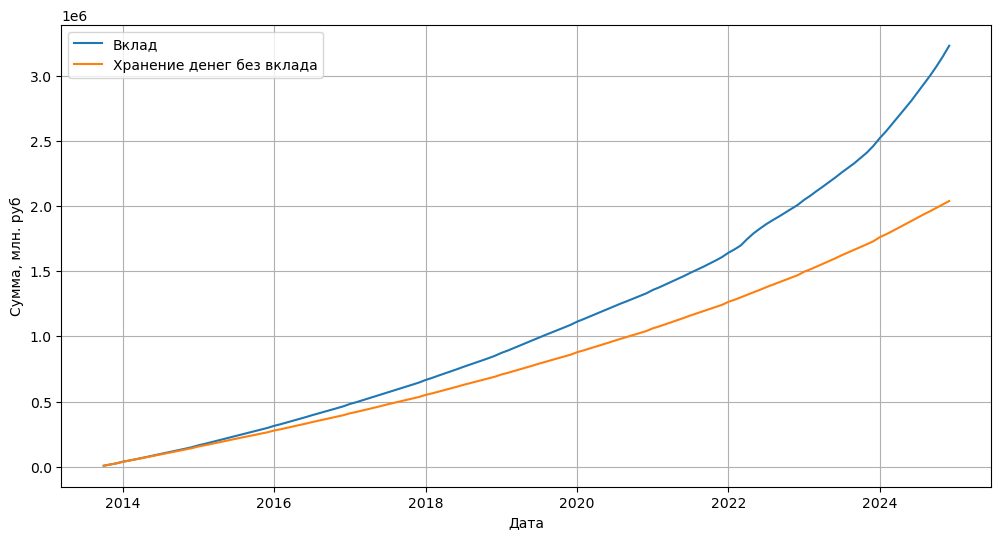

In [7]:
plt.figure(figsize = (12, 6))
plt.plot(deposit_inv["date"], deposit_inv["avialable_money"], label = "Вклад")
plt.plot(deposit_inv["date"], (deposit_inv["salary"] * 0.3).cumsum(), label = "Хранение денег без вклада")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Сумма, млн. руб")
plt.grid()

# Моделирование инвестиций в индекс мосбиржи

In [8]:
imoex_inv = pd.merge(salaries, imoex, how = "inner", on = "date")
imoex_inv[["rub", "imoex", "total"]] = [0, 0, 0]
imoex_inv.drop(["high", "low", "close"], axis = 1, inplace = True)

In [9]:
imoex_inv.loc[0, ["rub", "total"]] = imoex_inv.loc[0, "salary"] * 0.3, imoex_inv.loc[0, "salary"] * 0.3
imoex_inv.loc[0, "imoex"] = imoex_inv.loc[0, "rub"] // imoex_inv.loc[0, "open"]
imoex_inv.loc[0, "rub"] -= imoex_inv.loc[0, "imoex"] * imoex_inv.loc[0, "open"]
for i in range(1, len(imoex_inv)):
    imoex_inv.loc[i, "rub"] += imoex_inv.loc[i - 1, "rub"] + imoex_inv.loc[i, "salary"] * 0.3
    imoex_bought = imoex_inv.loc[i, "rub"] // imoex_inv.loc[i, "open"]
    imoex_inv.loc[i, "rub"] -= imoex_bought * imoex_inv.loc[i, "open"]
    imoex_inv.loc[i, "imoex"] += imoex_bought + imoex_inv.loc[i - 1, "imoex"]
    imoex_inv.loc[i, "total"] = imoex_inv.loc[i, "rub"] + imoex_inv.loc[i, "imoex"] * imoex_inv.loc[i, "open"]

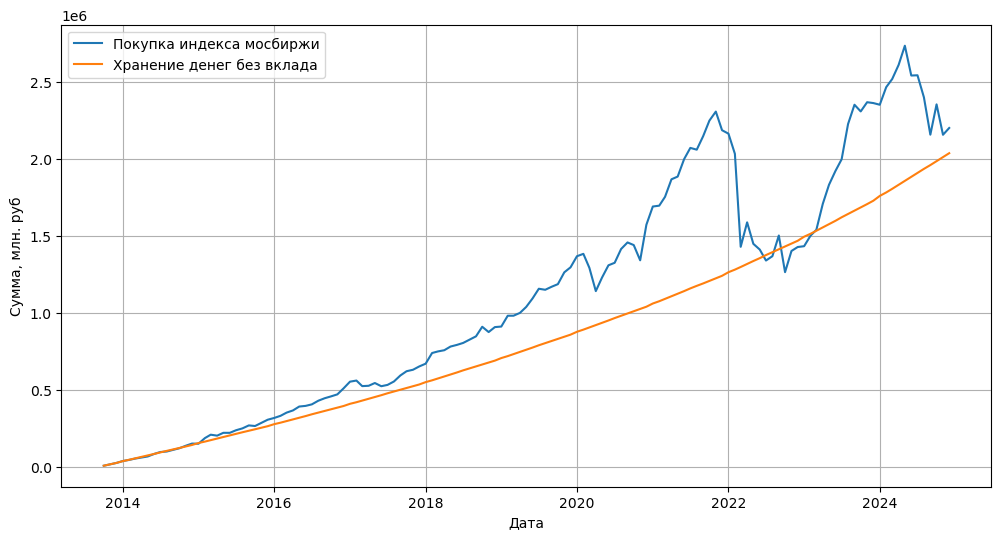

In [10]:
plt.figure(figsize = (12, 6))
plt.plot(imoex_inv["date"], imoex_inv["total"], label = "Покупка индекса мосбиржи")
plt.plot(imoex_inv["date"], (imoex_inv["salary"] * 0.3).cumsum(), label = "Хранение денег без вклада")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Сумма, млн. руб")
plt.grid()

# Моделирование инвестиций в доллары

In [11]:
dollar_inv = pd.merge(salaries, dollar, how = "inner", on = "date")
dollar_inv[["rub", "dollars", "total"]] = [0, 0, 0]
dollar_inv.drop(["high", "low", "close"], axis = 1, inplace = True)

In [12]:
dollar_inv.loc[0, ["rub", "total"]] = dollar_inv.loc[0, "salary"] * 0.3, dollar_inv.loc[0, "salary"] * 0.3
dollar_inv.loc[0, "dollars"] = dollar_inv.loc[0, "rub"] // dollar_inv.loc[0, "open"]
dollar_inv.loc[0, "rub"] -= dollar_inv.loc[0, "dollars"] * dollar_inv.loc[0, "open"]
for i in range(1, len(dollar_inv)):
    dollar_inv.loc[i, "rub"] += dollar_inv.loc[i - 1, "rub"] + dollar_inv.loc[i, "salary"] * 0.3
    dollars_bought = dollar_inv.loc[i, "rub"] // dollar_inv.loc[i, "open"]
    dollar_inv.loc[i, "rub"] -= dollars_bought * dollar_inv.loc[i, "open"]
    dollar_inv.loc[i, "dollars"] += dollars_bought + dollar_inv.loc[i - 1, "dollars"]
    dollar_inv.loc[i, "total"] = dollar_inv.loc[i, "rub"] + dollar_inv.loc[i, "dollars"] * dollar_inv.loc[i, "open"]

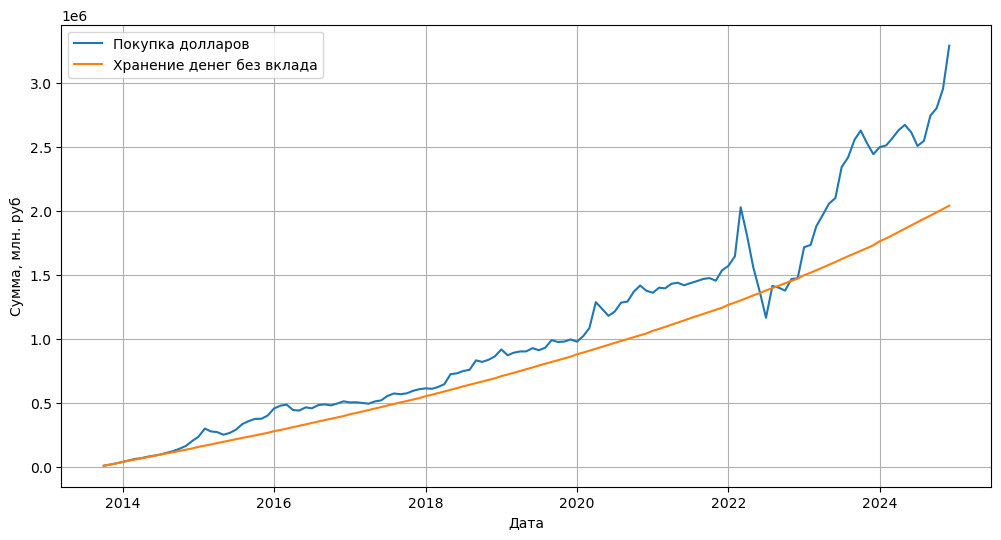

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(dollar_inv["date"], dollar_inv["total"], label = "Покупка долларов")
plt.plot(dollar_inv["date"], (dollar_inv["salary"] * 0.3).cumsum(), label = "Хранение денег без вклада")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Сумма, млн. руб")
plt.grid()

# Моделирование инвестиций в американский индекс s&p500

In [14]:
sp500_inv = pd.merge(salaries, sp500, how = "inner", on = "date")
sp500_inv[["rub", "sp500", "total"]] = [0, 0, 0]
sp500_inv.drop(["high", "low", "close"], axis = 1, inplace = True)

In [15]:
sp500_inv.loc[0, ["rub", "total"]] = sp500_inv.loc[0, "salary"] * 0.3, sp500_inv.loc[0, "salary"] * 0.3
sp500_inv.loc[0, "sp500"] = sp500_inv.loc[0, "rub"] // sp500_inv.loc[0, "open"]
sp500_inv.loc[0, "rub"] -= sp500_inv.loc[0, "sp500"] * sp500_inv.loc[0, "open"]
for i in range(1, len(sp500_inv)):
    sp500_inv.loc[i, "rub"] += sp500_inv.loc[i - 1, "rub"] + sp500_inv.loc[i, "salary"] * 0.3
    sp500_bought = sp500_inv.loc[i, "rub"] // sp500_inv.loc[i, "open"]
    sp500_inv.loc[i, "rub"] -= sp500_bought * sp500_inv.loc[i, "open"]
    sp500_inv.loc[i, "sp500"] += sp500_bought + sp500_inv.loc[i - 1, "sp500"]
    sp500_inv.loc[i, "total"] = sp500_inv.loc[i, "rub"] + sp500_inv.loc[i, "sp500"] * sp500_inv.loc[i, "open"]

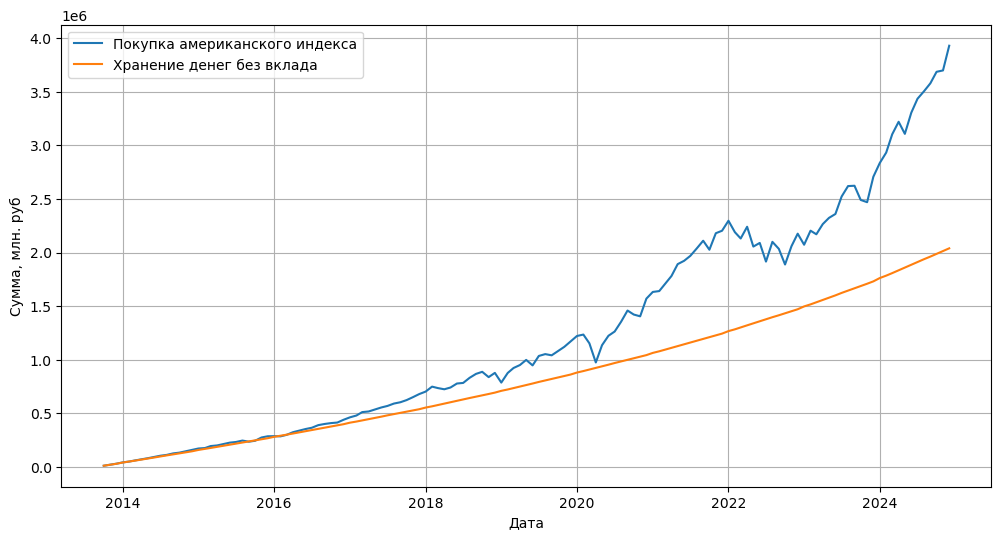

In [16]:
plt.figure(figsize = (12, 6))
plt.plot(sp500_inv["date"], sp500_inv["total"], label = "Покупка американского индекса")
plt.plot(sp500_inv["date"], (sp500_inv["salary"] * 0.3).cumsum(), label = "Хранение денег без вклада")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Сумма, млн. руб")
plt.grid()

# Моделирование инвестирования в золото

In [17]:
gold_inv = salaries.copy(deep = True)
for i in range(len(salaries)):
    gold_inv.loc[i, "open"] = gold.loc[gold[gold["date"] > gold_inv.loc[i, "date"]]["date"].idxmin()].price
gold_inv[["rub", "gold", "total"]] = [0, 0, 0]

In [18]:
gold_inv.loc[0, ["rub", "total"]] = gold_inv.loc[0, "salary"] * 0.3, gold_inv.loc[0, "salary"] * 0.3
gold_inv.loc[0, "gold"] = gold_inv.loc[0, "rub"] // gold_inv.loc[0, "open"]
gold_inv.loc[0, "rub"] -= gold_inv.loc[0, "gold"] * gold_inv.loc[0, "open"]
for i in range(1, len(gold_inv)):
    gold_inv.loc[i, "rub"] += gold_inv.loc[i - 1, "rub"] + gold_inv.loc[i, "salary"] * 0.3
    gold_bought = gold_inv.loc[i, "rub"] // gold_inv.loc[i, "open"]
    gold_inv.loc[i, "rub"] -= gold_bought * gold_inv.loc[i, "open"]
    gold_inv.loc[i, "gold"] += gold_bought + gold_inv.loc[i - 1, "gold"]
    gold_inv.loc[i, "total"] = gold_inv.loc[i, "rub"] + gold_inv.loc[i, "gold"] * gold_inv.loc[i, "open"]

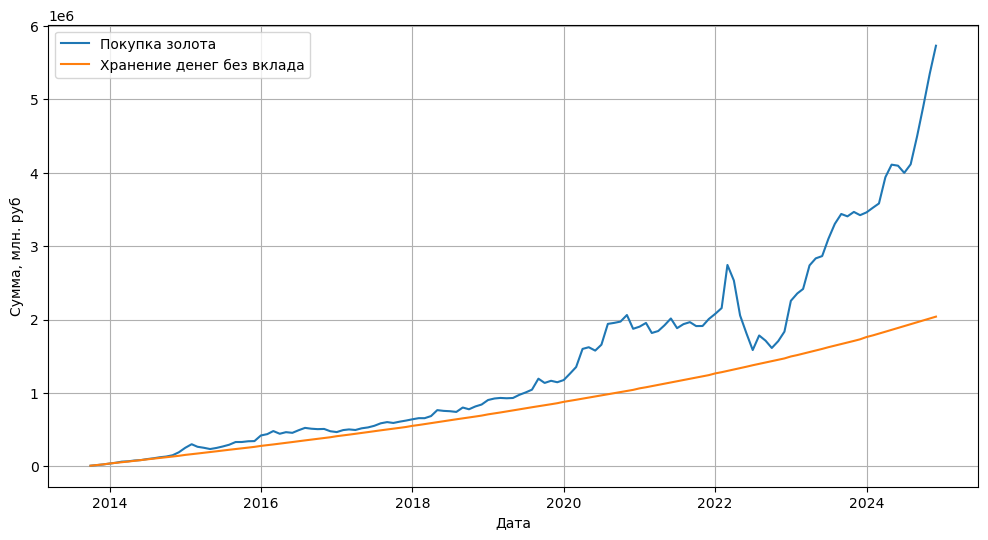

In [19]:
plt.figure(figsize = (12, 6))
plt.plot(gold_inv["date"], gold_inv["total"], label = "Покупка золота")
plt.plot(gold_inv["date"], (gold_inv["salary"] * 0.3).cumsum(), label = "Хранение денег без вклада")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Сумма, млн. руб")
plt.grid()

# Сравнение всех видос инвестиций

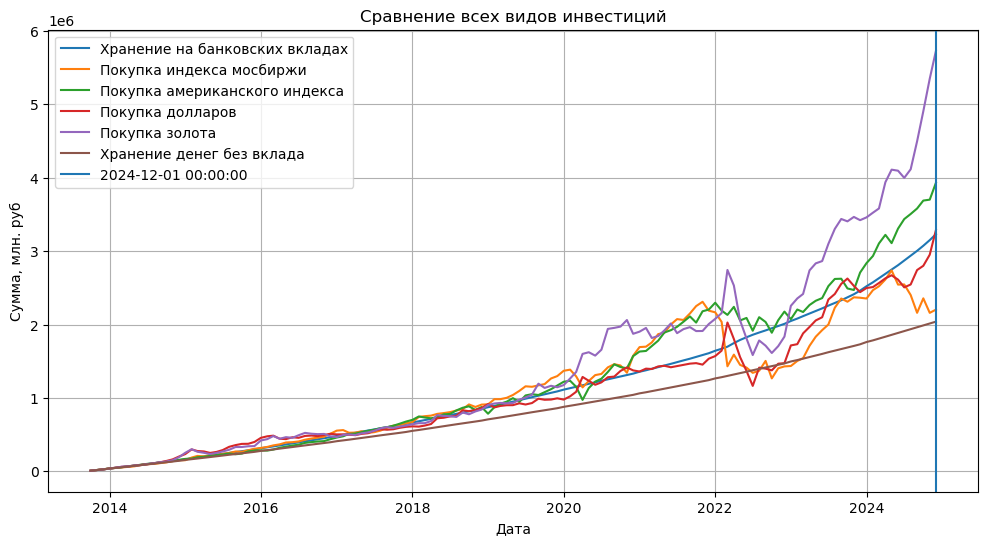

In [20]:
plt.figure(figsize = (12, 6))
total_saved_salary = (gold_inv["salary"] * 0.3).cumsum()
plt.plot(deposit_inv["date"], deposit_inv["avialable_money"], label = "Хранение на банковских вкладах")
plt.plot(imoex_inv["date"], imoex_inv["total"], label = "Покупка индекса мосбиржи")
plt.plot(sp500_inv["date"], sp500_inv["total"], label = "Покупка американского индекса")
plt.plot(dollar_inv["date"], dollar_inv["total"], label = "Покупка долларов")
plt.plot(gold_inv["date"], gold_inv["total"], label = "Покупка золота")
plt.plot(gold_inv["date"], total_saved_salary, label = "Хранение денег без вклада")
plt.axvline(deposit_inv.date.max(), label = f"{deposit_inv.date.max()}")
plt.title("Сравнение всех видов инвестиций")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Сумма, млн. руб")
plt.grid()

In [21]:
print(f"Итоговая сумма (вклады в банке): {deposit_inv.iloc[-1].avialable_money:.3f}")
print(f"Итоговая сумма (индекс мосбиржи): {imoex_inv.iloc[-1].total:.3f}")
print(f"Итоговая сумма (покупка долларов): {dollar_inv.iloc[-1].total:.3f}")
print(f"Итоговая сумма (покупка s&p500): {sp500_inv.iloc[-1].total:.3f}")
print(f"Итоговая сумма (покупка золота): {gold_inv.iloc[-1].total:.3f}")
print(f"Итоговая сумма (сохранение зарплаты): {total_saved_salary.iloc[-1]:.3f}")

Итоговая сумма (вклады в банке): 3230303.328
Итоговая сумма (индекс мосбиржи): 2203113.640
Итоговая сумма (покупка долларов): 3288605.191
Итоговая сумма (покупка s&p500): 3931602.750
Итоговая сумма (покупка золота): 5729039.360
Итоговая сумма (сохранение зарплаты): 2039260.230
